# Photometry data preprocessing

This notebook shows methods for preprocessing fiber photometry data. The preprocessing consists of the following steps:

1. Lowpass filtering to reduce noise.

2. Correction for photobleaching, i.e. the slow decreace in the fluorescence signal over time.  Two different methods are shown (i) subtraction of a double exponential fit (ii) highpass filtering with a very low cutoff frequency.

2. Movement correction by subtracting a linear fit of the movement control channel.

4. Conversion of the signal to dF/F.

Note that different groups do preprocessing differently and there is no universally accepted best practice for how to preprocess photometry data.  The best way to preprocess your data may depend on the details of the experimental setup and the questions you want to ask of the data. It is good practice to always visually inspect the raw data and the results of each preprocessing step to make sure they look sensible.  

The data used in this notebook were recorded from dLight expressed in the nucleus accumbens core during a reward guided decision task ([Blanco-pozo et al 2023](https://www.biorxiv.org/content/10.1101/2021.06.25.449995v3)).  The data were recorded using [pyPhotometry](https://pyphotometry.readthedocs.io) acquisition hardware, using the *two colour time division* acquisition mode with dLight as the dopamine sensor  and TdTomato as a movement control channel.

In [1]:
%matplotlib widget

Import the standard python modules needed for the analysis.

In [2]:
import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

#set default plot properties
plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.
plt.rcParams['axes.labelsize'] = 12     #Set default axes label size 
plt.rcParams['axes.titlesize']=15
plt.rcParams['axes.titleweight']='heavy'
plt.rcParams['ytick.labelsize']= 10
plt.rcParams['xtick.labelsize']= 10
plt.rcParams['legend.fontsize']=12
plt.rcParams['legend.markerscale']=2

Import the pyPhotometry [data import](https://pyphotometry.readthedocs.io/en/latest/user-guide/importing-data/) module.

In [3]:
from data_import import import_ppd

In [4]:
animal = "IM-1641"
date = "05022024"
ses_type = "barrier"

Import the photometry data and times of reward cues.

In [5]:
data_folder = "W:/Photometry/"+ animal + '/' + date + '/'
data_filename = 'IM-1641_NAcC_R-2024-05-02-163928.ppd' 
data = import_ppd(os.path.join(data_folder, data_filename))

Extract the raw dLight and TdTomato signals, session time, and sampling rate.

In [7]:
dLight_raw = data['analog_1']
TdTom_raw = data['analog_3']
time_seconds = data['time']/1000
sampling_rate = data['sampling_rate']

# Raw signals

Let's take a look at the raw dLight and TdTomato signals.

Text(0.5, 1.0, 'Raw signals')

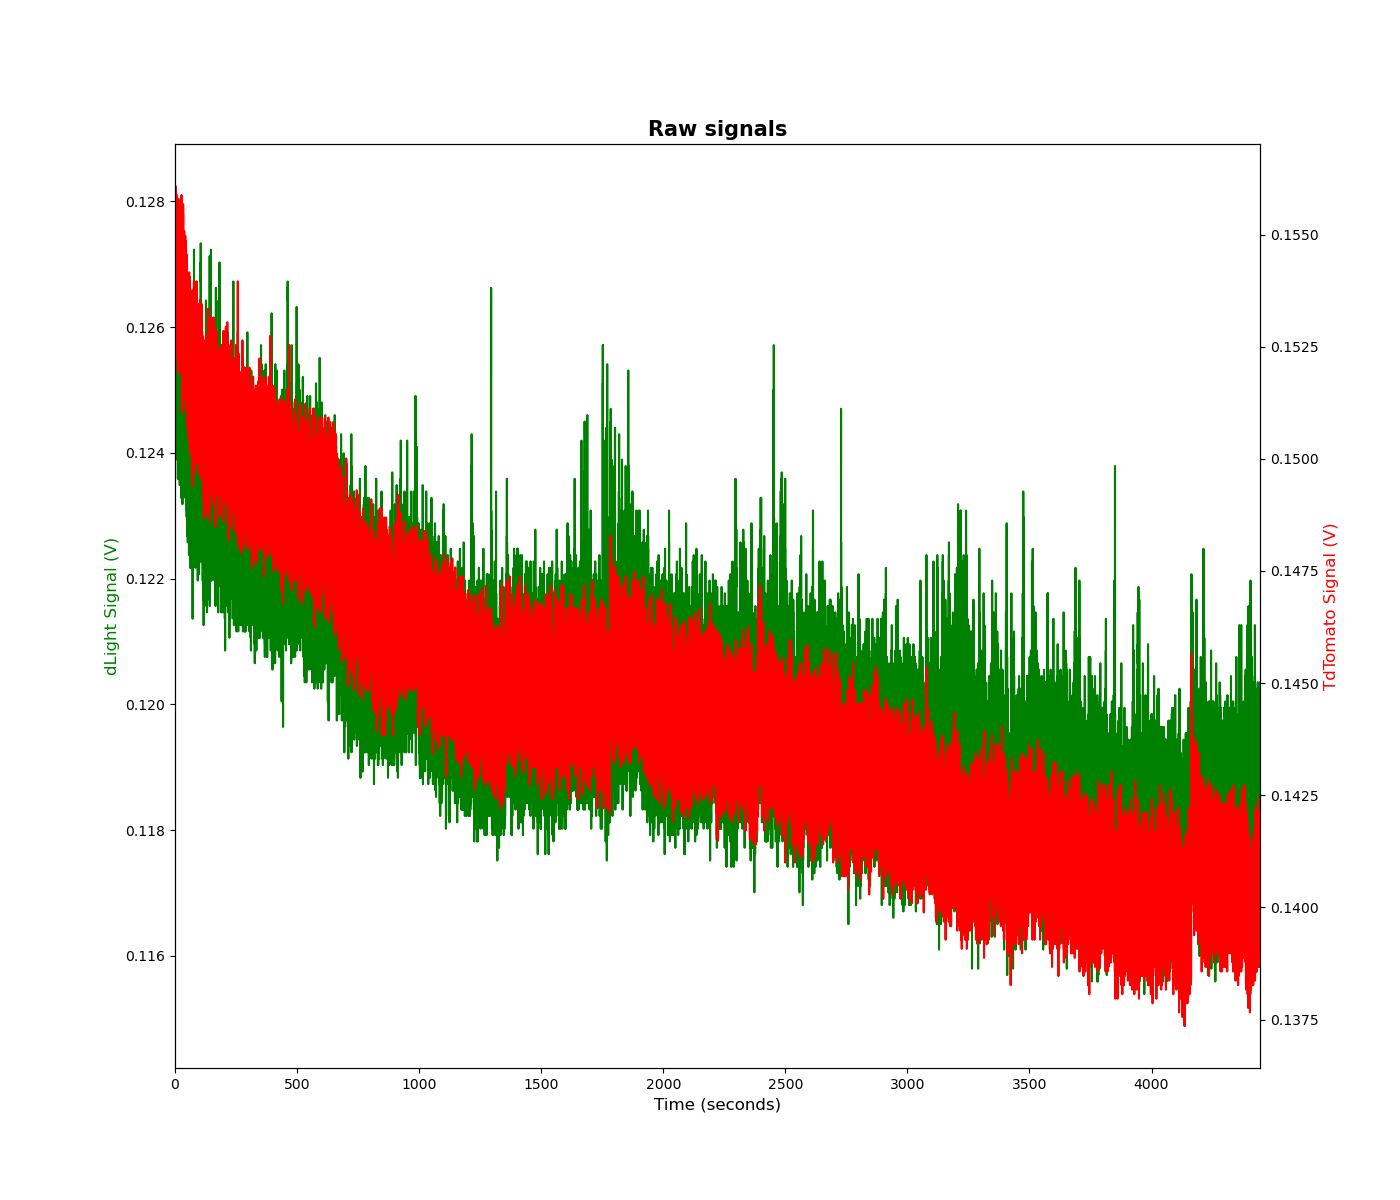

In [8]:
# Plot signals

fig,ax1=plt.subplots()  # create a plot to allow for dual y-axes plotting
plot1=ax1.plot(time_seconds, dLight_raw, 'g', label='dLight') #plot dLight on left y-axis
ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
plot2=ax2.plot(time_seconds, TdTom_raw, 'r', label='TdTomato') # plot TdTomato on right y-axis

# ax1.set_ylim(1.25, 1.65)
# ax2.set_ylim(1.35, 1.75)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight Signal (V)', color='g')
ax2.set_ylabel('TdTomato Signal (V)', color='r')
ax1.set_title('Raw signals')


# Denoising

We lowpass filter the signals to reduce high frequency noise, using a zero phase filter with a 10Hz cutoff frequency.

Text(0.5, 1.0, 'Denoised signals')

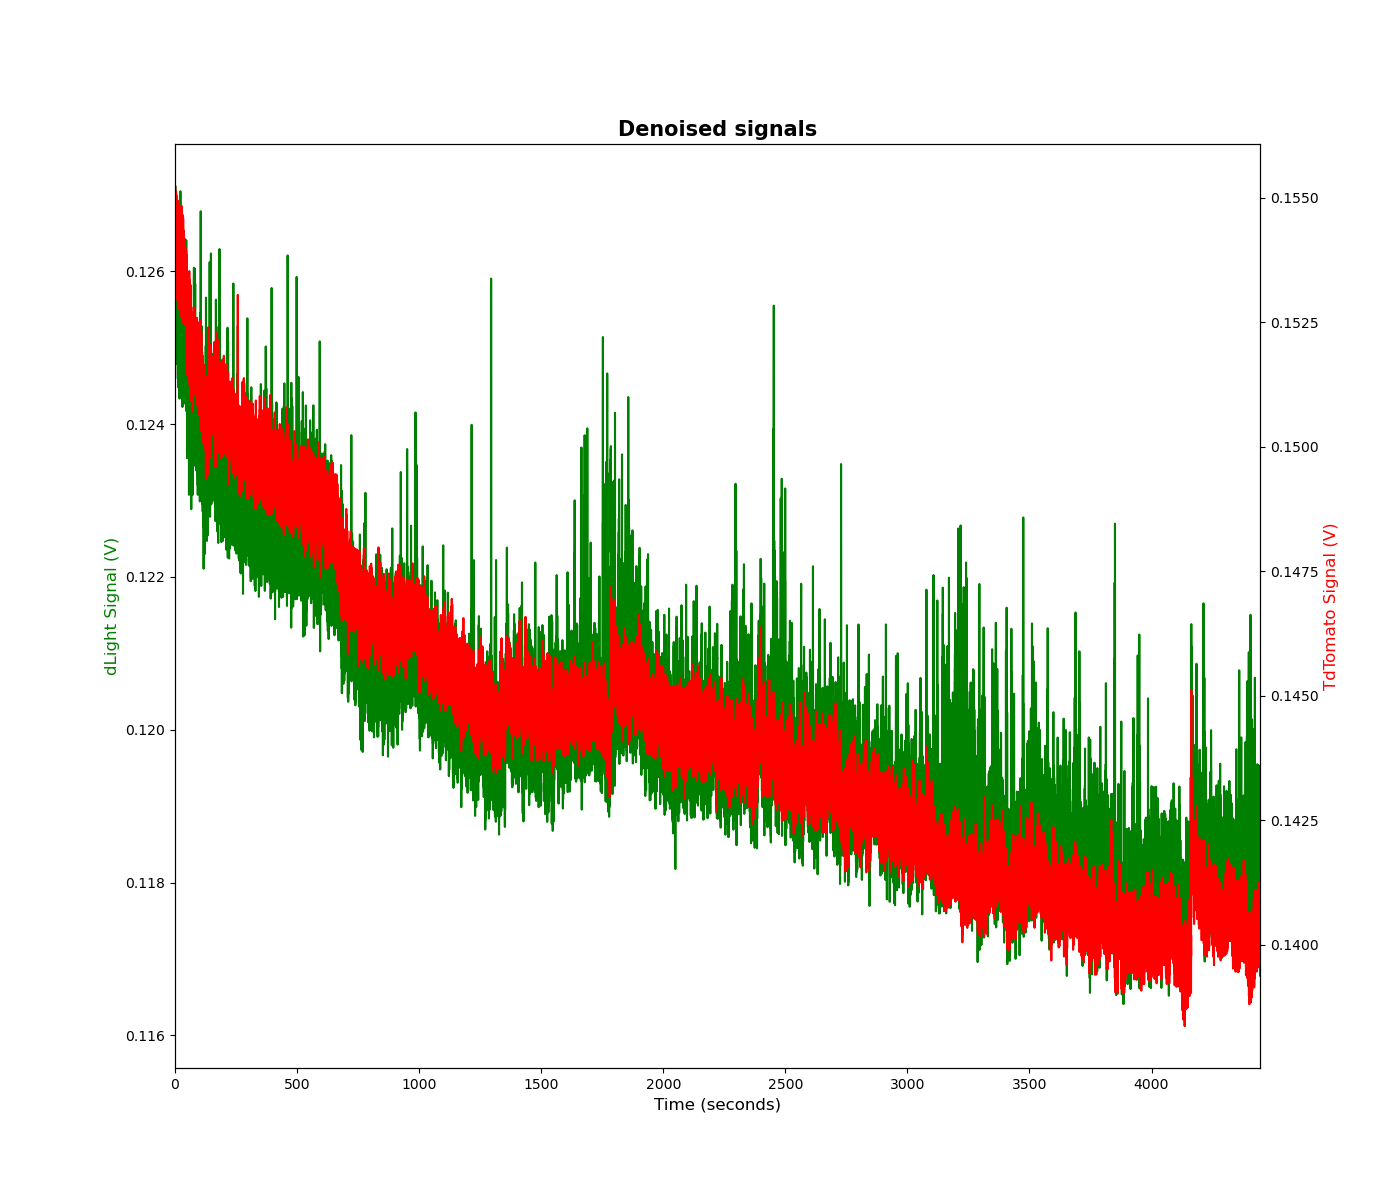

In [9]:
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 10, btype='low', fs=sampling_rate)
dLight_denoised = filtfilt(b,a, dLight_raw)
TdTom_denoised = filtfilt(b,a, TdTom_raw)

fig,ax1=plt.subplots()
plot1=ax1.plot(time_seconds, dLight_denoised, 'g', label='dLight denoised')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, TdTom_denoised, 'r', label='TdTomato denoised')

# ax1.set_ylim(1.25, 1.65)
# ax2.set_ylim(1.35, 1.75)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight Signal (V)', color='g')
ax2.set_ylabel('TdTomato Signal (V)', color='r')
ax1.set_title('Denoised signals')


Let's zoom in on the x axis to see how the lowpass filtering has smoothed the signals.

Text(0.5, 1.0, 'Denoised signals')

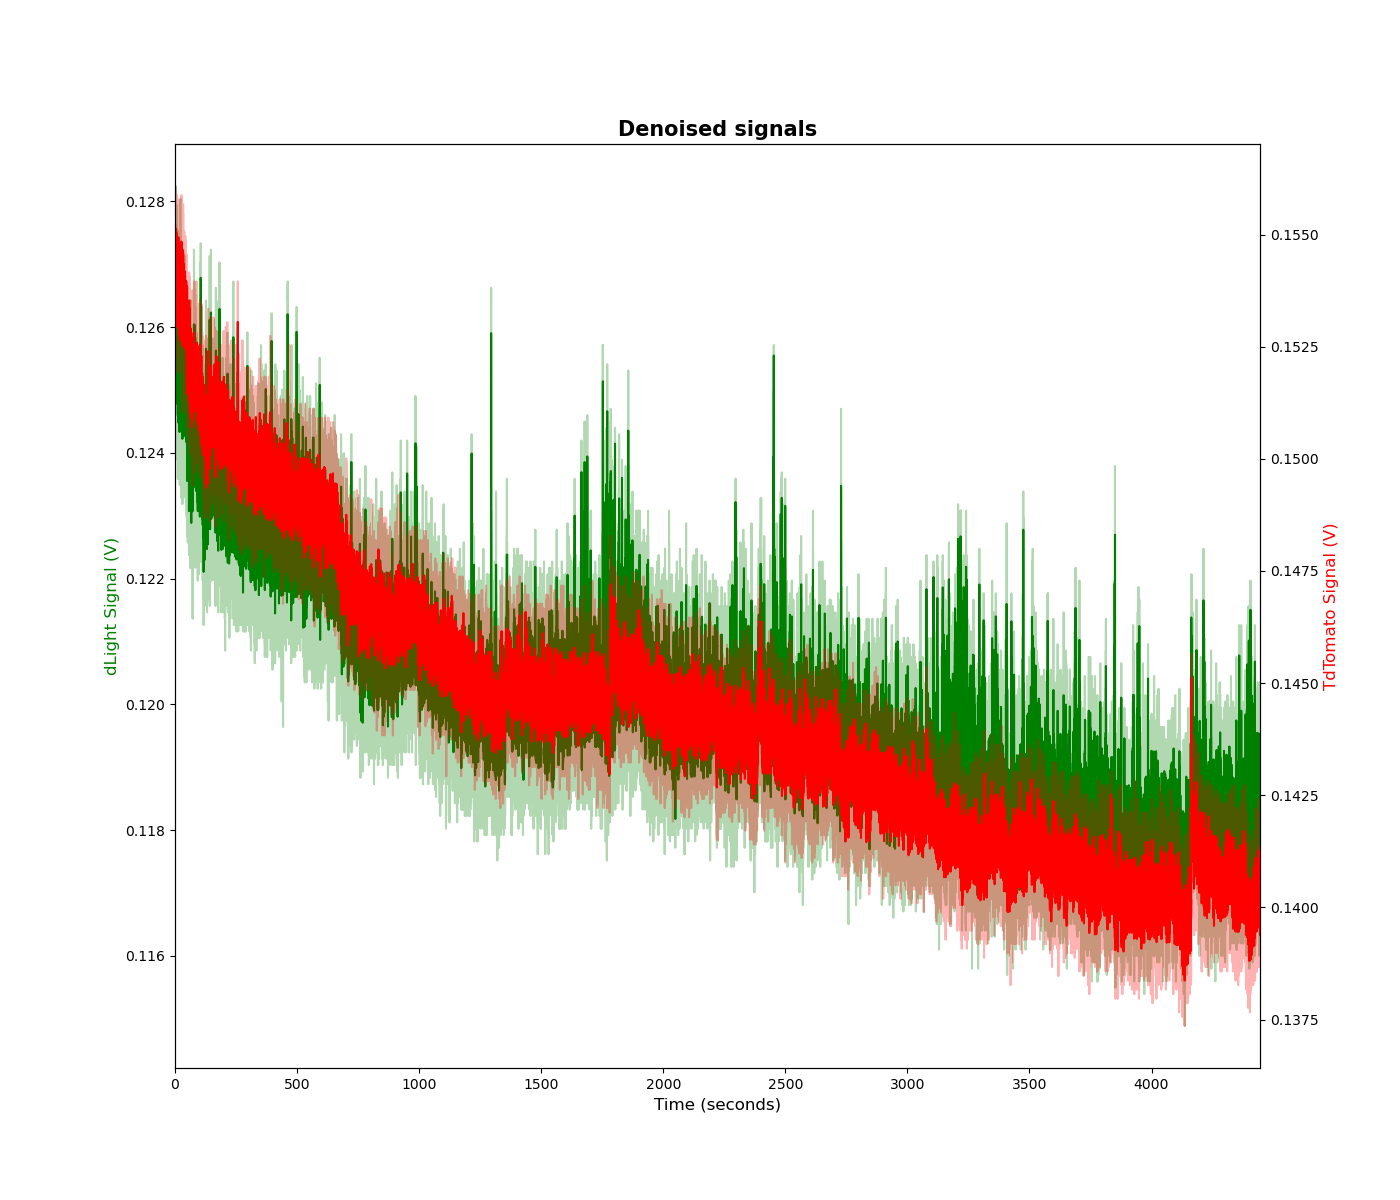

In [10]:
fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds, dLight_raw, color='g', alpha=0.3, label='dLight raw')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, TdTom_raw, color='r', alpha=0.3, label='TdTomato raw') 
plot3=ax1.plot(time_seconds, dLight_denoised, color='g', label='dLight denoised') 
plot4=ax2.plot(time_seconds, TdTom_denoised, color='r', label='TdTomato denoised') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight Signal (V)', color='g')
ax2.set_ylabel('TdTomato Signal (V)', color='r')
ax1.set_title('Denoised signals')


# Photobleaching correction

Now lets compare some different ways of removing the influence of photobleaching.

### Method 1: Double Exponential Fit

One way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal (note, some groups divide the signal by the baseline rather than subtracting the baseline, see Fiber Photometry Primer for more discussion). In practice we find that a double exponential fit is preferable to a single exponential fit because there are typically multiple sources of fluorescence that contribute to the bleaching (e.g. autofluorescence from fiber, autofluorescence from brain tissue, and flurophore fluorescence), which may bleach at different rates, so a single exponential fit can be overly restrictive.

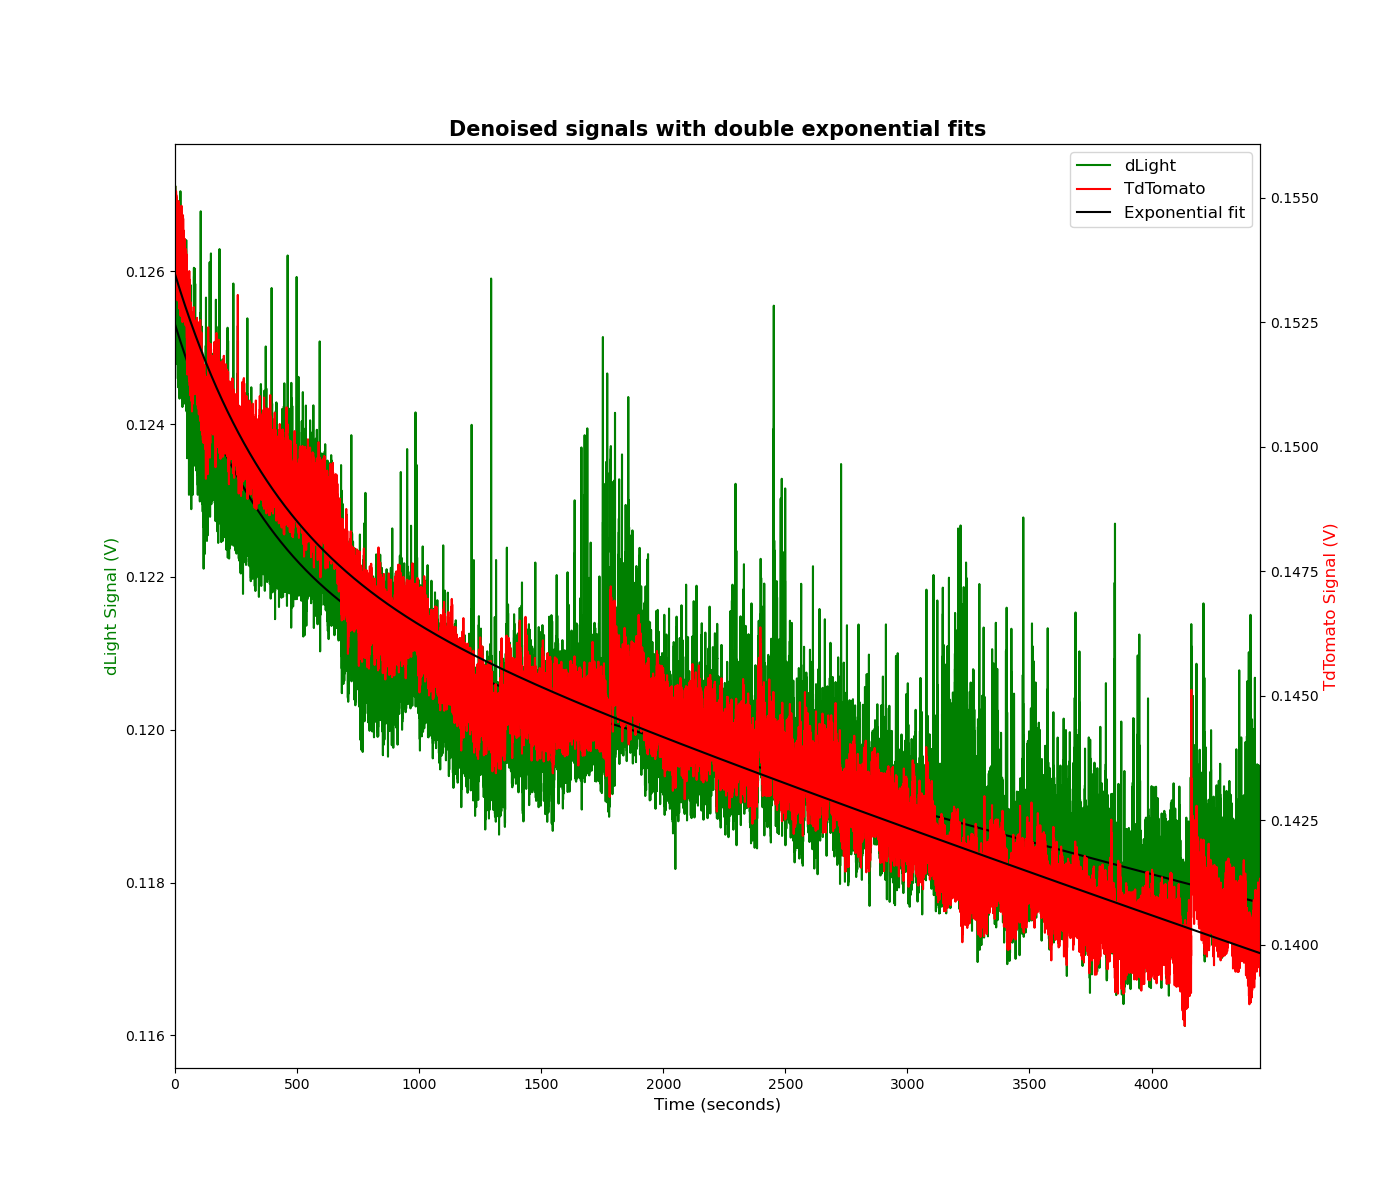

In [11]:
# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset. 
    amp_fast: Amplitude of the fast component.  
    amp_slow: Amplitude of the slow component.  
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow. 
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

# Fit curve to dLight signal.
max_sig = np.max(dLight_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
dLight_parms, parm_cov = curve_fit(double_exponential, time_seconds, dLight_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
dLight_expfit = double_exponential(time_seconds, *dLight_parms)

# Fit curve to TdTomato signal.
max_sig = np.max(TdTom_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
TdTom_parms, parm_cov = curve_fit(double_exponential, time_seconds, TdTom_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
TdTom_expfit = double_exponential(time_seconds, *TdTom_parms)

#plot fits over denoised data
fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds, dLight_denoised, 'g', label='dLight')
plot3=ax1.plot(time_seconds, dLight_expfit, color='k', linewidth=1.5, label='Exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, TdTom_denoised, color='r', label='TdTomato') 
plot4=ax2.plot(time_seconds, TdTom_expfit,color='k', linewidth=1.5) 


ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight Signal (V)', color='g')
ax2.set_ylabel('TdTomato Signal (V)', color='r')
ax1.set_title('Denoised signals with double exponential fits')

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
# ax1.set_ylim(1.27, 1.62)
# ax2.set_ylim(1.35, 1.7);


In this data there is substantial bleaching in the dLight channel but no appreciable bleaching in the tdTomato. 

Now we subtract the exponential fits from the signals.

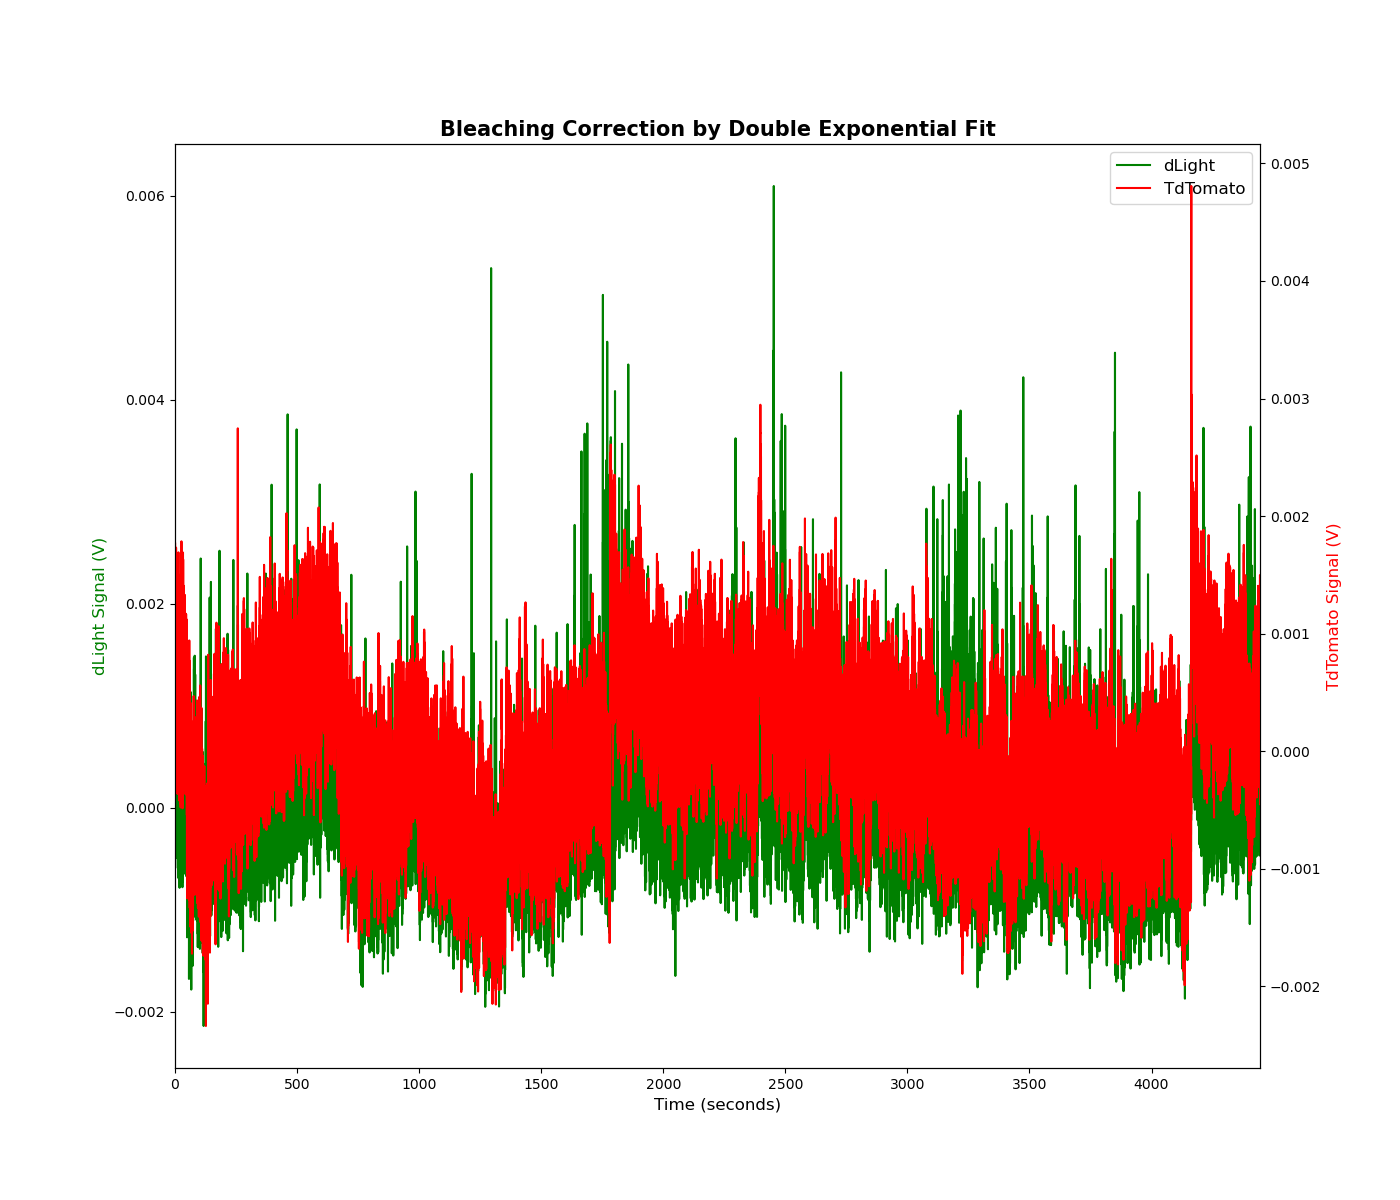

In [12]:
dLight_detrended = dLight_denoised - dLight_expfit
TdTom_detrended = TdTom_denoised - TdTom_expfit

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds, dLight_detrended, 'g', label='dLight')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, TdTom_detrended, color='r', label='TdTomato') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight Signal (V)', color='g')
ax2.set_ylabel('TdTomato Signal (V)', color='r')
ax1.set_title('Bleaching Correction by Double Exponential Fit')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
# ax1.set_ylim(-0.18, 0.12)
# ax2.set_ylim(-0.1, 0.2);


### Method 2: High Pass Filter
A simpler way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes.  All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.


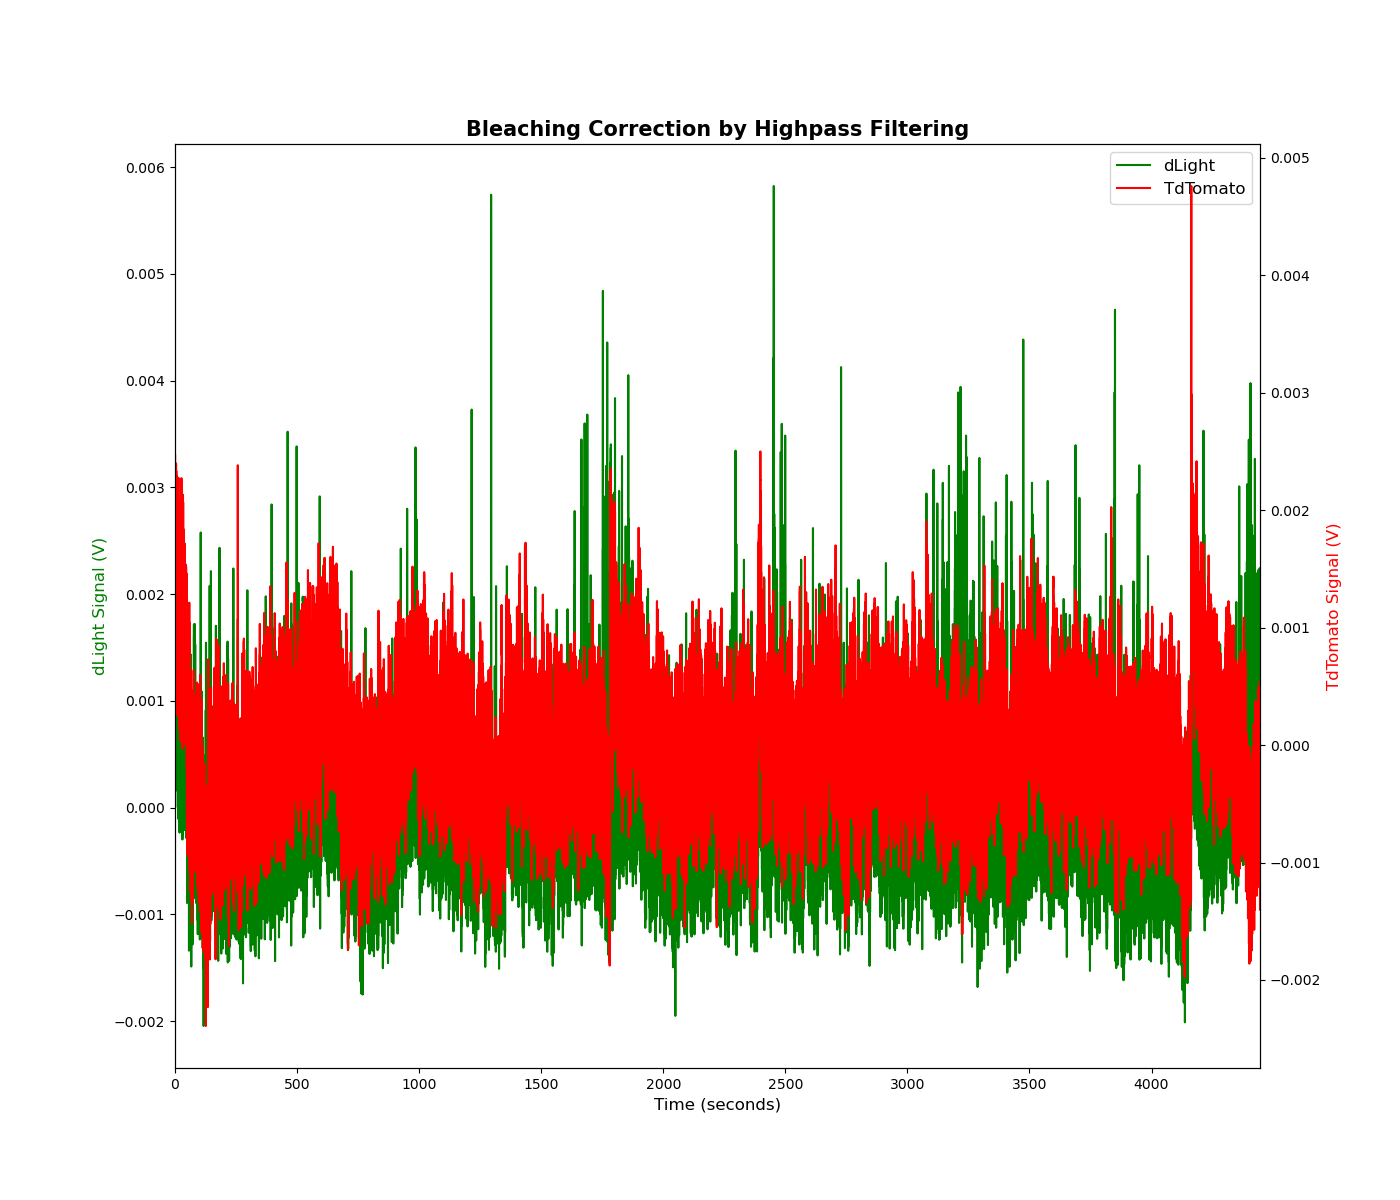

In [13]:
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
dLight_highpass = filtfilt(b,a, dLight_denoised, padtype='even')
TdTom_highpass = filtfilt(b,a, TdTom_denoised, padtype='even')


fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds, dLight_highpass, 'g', label='dLight')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds, TdTom_highpass, color='r', label='TdTomato') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight Signal (V)', color='g')
ax2.set_ylabel('TdTomato Signal (V)', color='r')
ax1.set_title('Bleaching Correction by Highpass Filtering')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
# ax1.set_ylim(-0.18, 0.12)
# ax2.set_ylim(-0.1, 0.2);


# Motion correction

We now do motion correction by finding the best linear fit of the TdTomato signal to the dLight signal and subtracting this estimated motion component from the dLight signal.  We will use the data that was bleaching corrected using the double exponential fit as this is less likely to remove meaningful slow variation in the signals.

In [14]:
slope, intercept, r_value, p_value, std_err = linregress(x=TdTom_detrended, y=dLight_detrended)

plt.scatter(TdTom_detrended[::5], dLight_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('TdTomato')
plt.ylabel('dLight')
plt.title('TdTomato - dLight correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

Slope    : 0.549
R-squared: 0.322


We can see that as expected the signals have a positive correlation due to the common contribution of movement to each.  We can also see from the slope of the fit being 0.23 that the movement artifacts in the dLight channel are aproximately 5x smaller than in the tdTomato channel.  This is likely because the shorter wavelength excitation light used for dLight excites much more autofluorescence from patch cords and bulk brain tissue, and as a large area diffuse source, autofluorescence is generally less affected by movement. For the same reason movement artifacts in isosbestic control channels, which use short wavelength excitation, are typically smaller than in the dLight channel.

We now calculate the estimated motion component of the dLight signal and subtract to get the motion corrected signal.

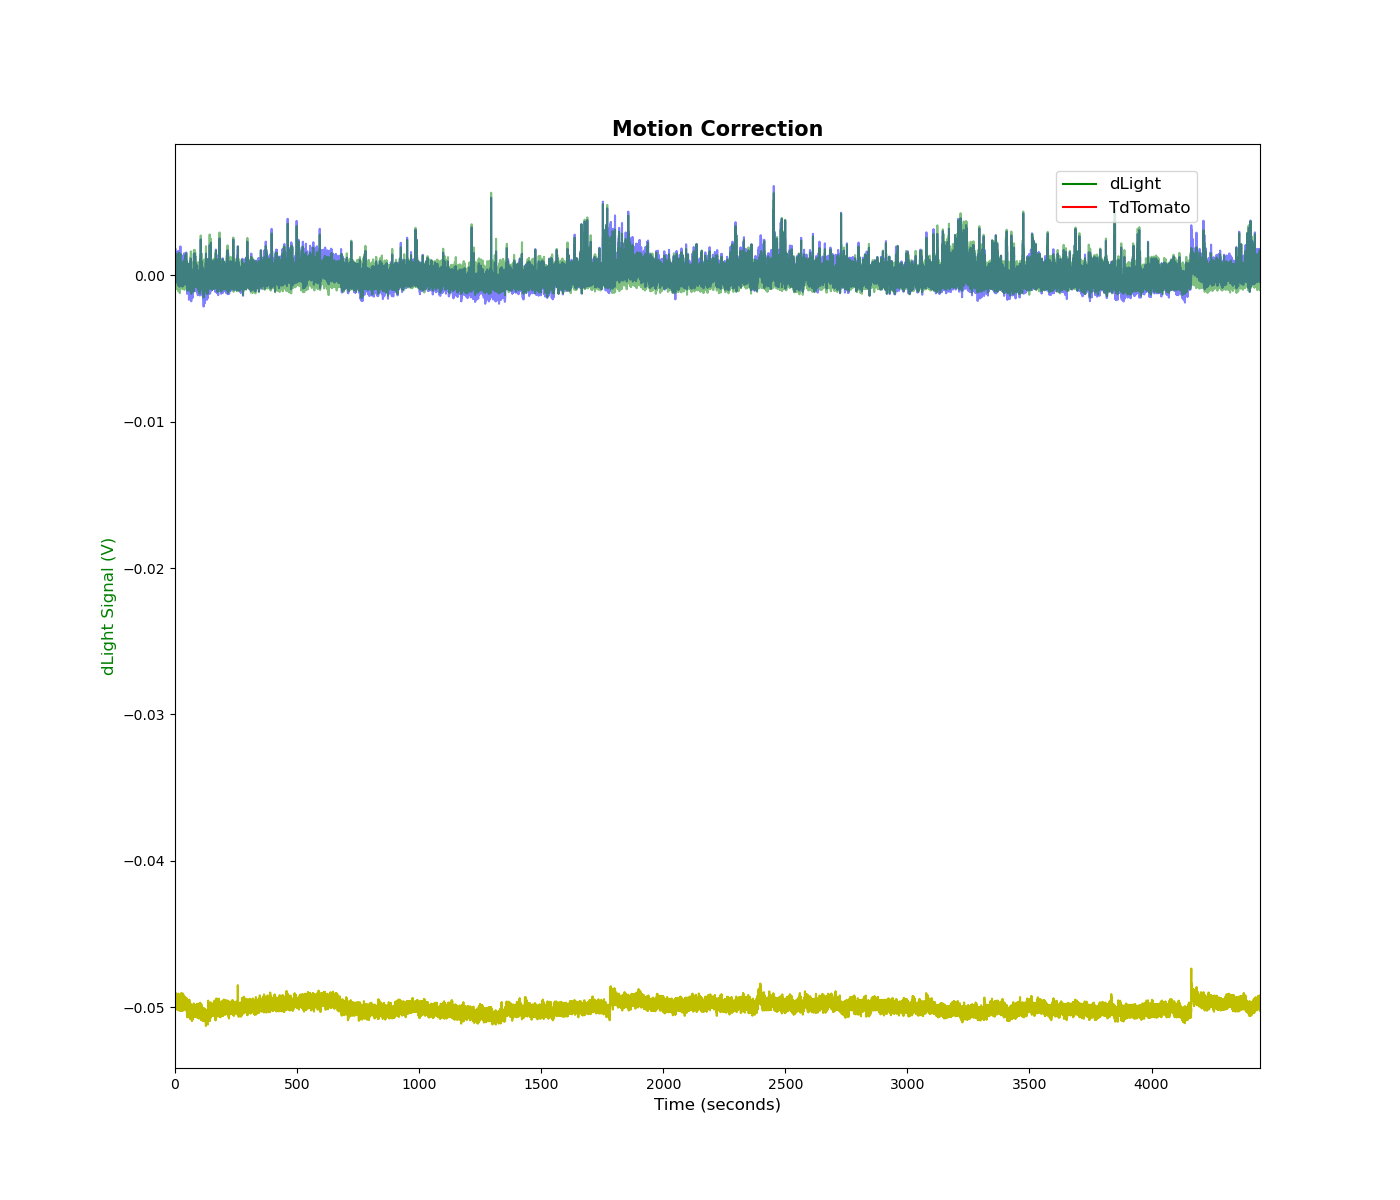

In [15]:
dLight_est_motion = intercept + slope * TdTom_detrended
dLight_corrected = dLight_detrended - dLight_est_motion

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds, dLight_detrended, 'b' , label='dLight - pre motion correction', alpha=0.5)
plot3=ax1.plot(time_seconds, dLight_corrected, 'g', label='dLight - motion corrected', alpha=0.5)
plot4=ax1.plot(time_seconds, dLight_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight Signal (V)', color='g')
ax1.set_title('Motion Correction')


legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

# ax1.set_xlim(0, 60)


# Normalisation

Typically in a photometry experiment we want to combine data across sessions and/or subjects.  This is complicated by the fact that different sessions may have different levels of fluorphore expression, excitation light and autofluorescence.  It is therefore desirable to normalise the data to reduce this variability.  The two most widely used ways of doing this are computing dF/F or z-scores.

### Method 1: dF/F

To compute dF/F we divide the signal changes (dF) by the baseline fluorescence (F) and multiply by 100 to convert to percent. The dF is just the motion corrected signal plotted above.  The baseline fluorescence F changes over the course of the session due to photobleaching, and is just the baseline we estimated with our double exponential fit.

Text(0.5, 1.0, 'dLight dF/F')

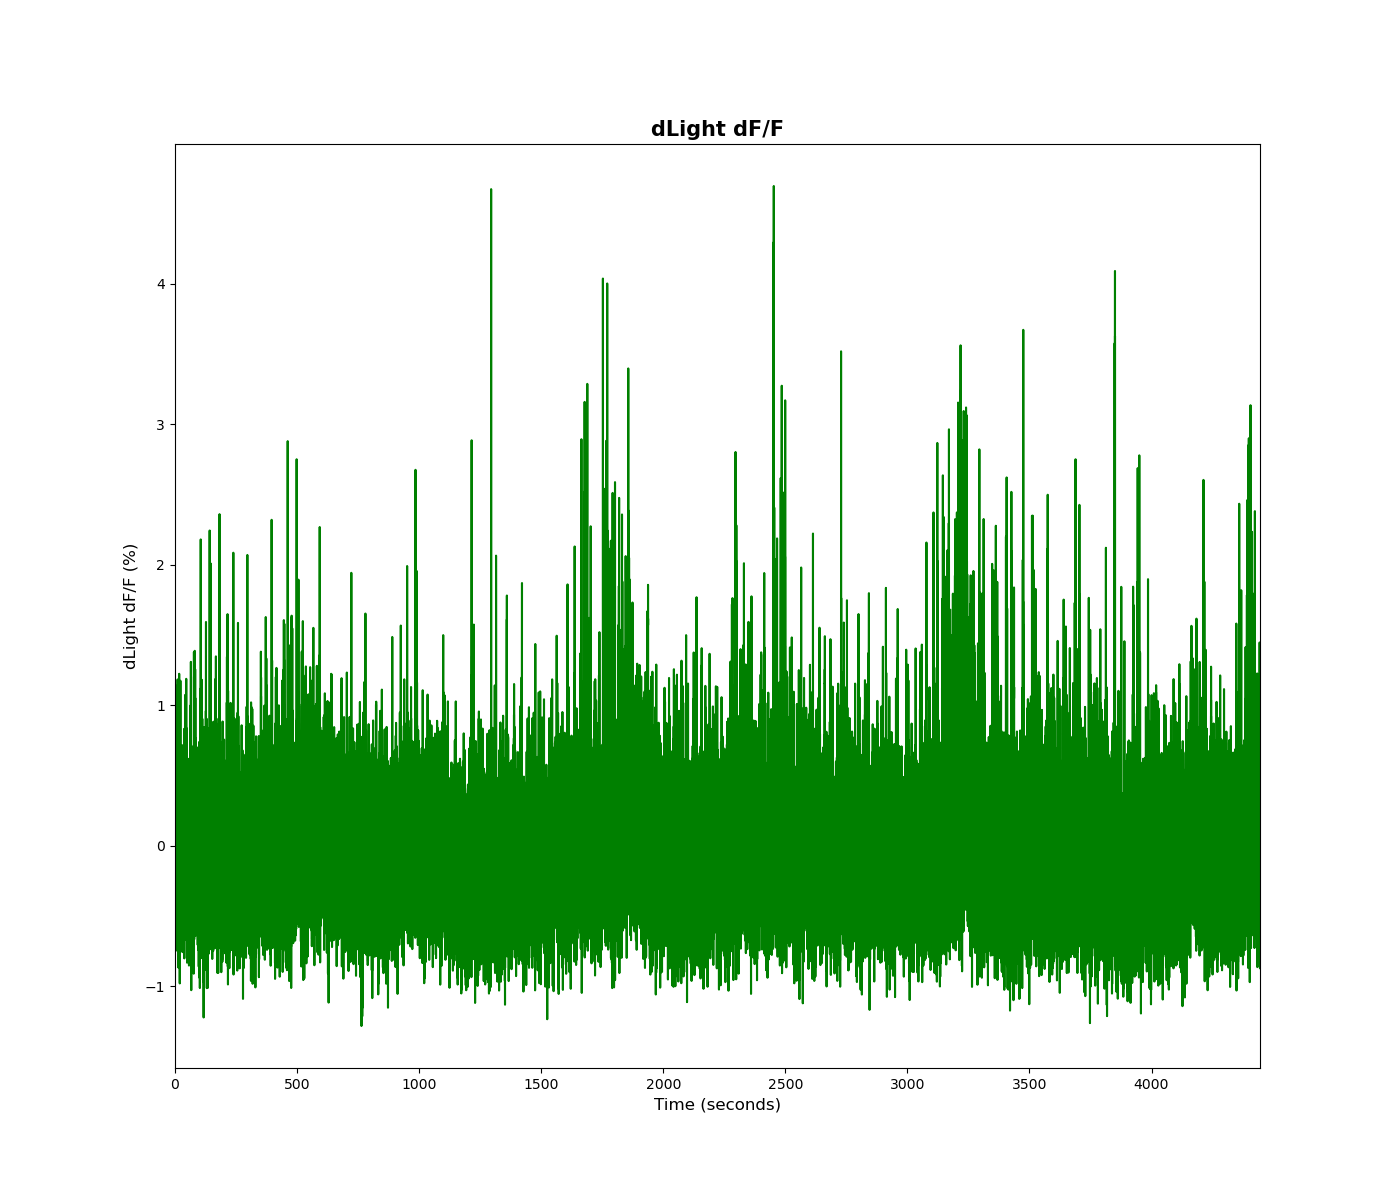

In [16]:
dLight_dF_F = 100*dLight_corrected/dLight_expfit

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds, dLight_dF_F, 'g', label='dLight dF/F')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight dF/F (%)')
ax1.set_title('dLight dF/F')

# ax1.set_xlim(0, 60)
#ax1.set_ylim(-3, 7);

### Method 2: Z-scoring

Alternatively, we can normalise the data by z-scoring each session - i.e. subtracting the mean and dividing by the standard deviation.

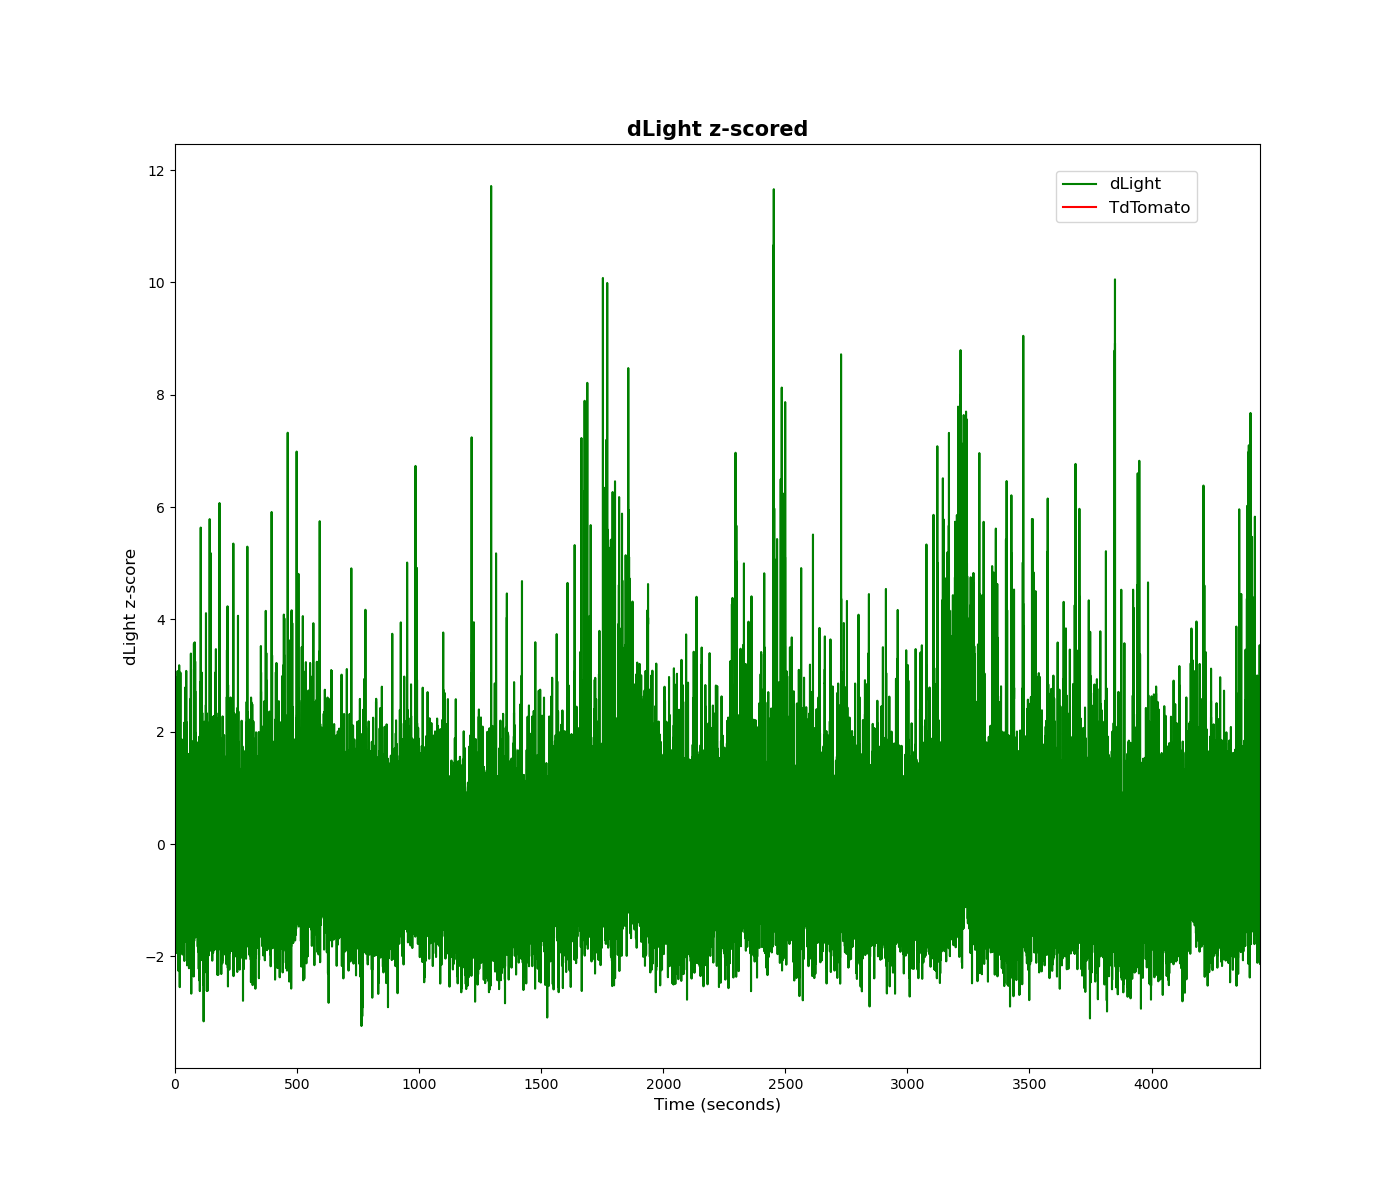

In [17]:
dLight_zscored = (dLight_corrected-np.mean(dLight_corrected))/np.std(dLight_corrected)


fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds, dLight_zscored, 'g', label='dLight z-score')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight z-score')
ax1.set_title('dLight z-scored')

legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

# ax1.set_xlim(0, 60)
# ax1.set_ylim(-3, 7);



### Method : Aligning with port entry


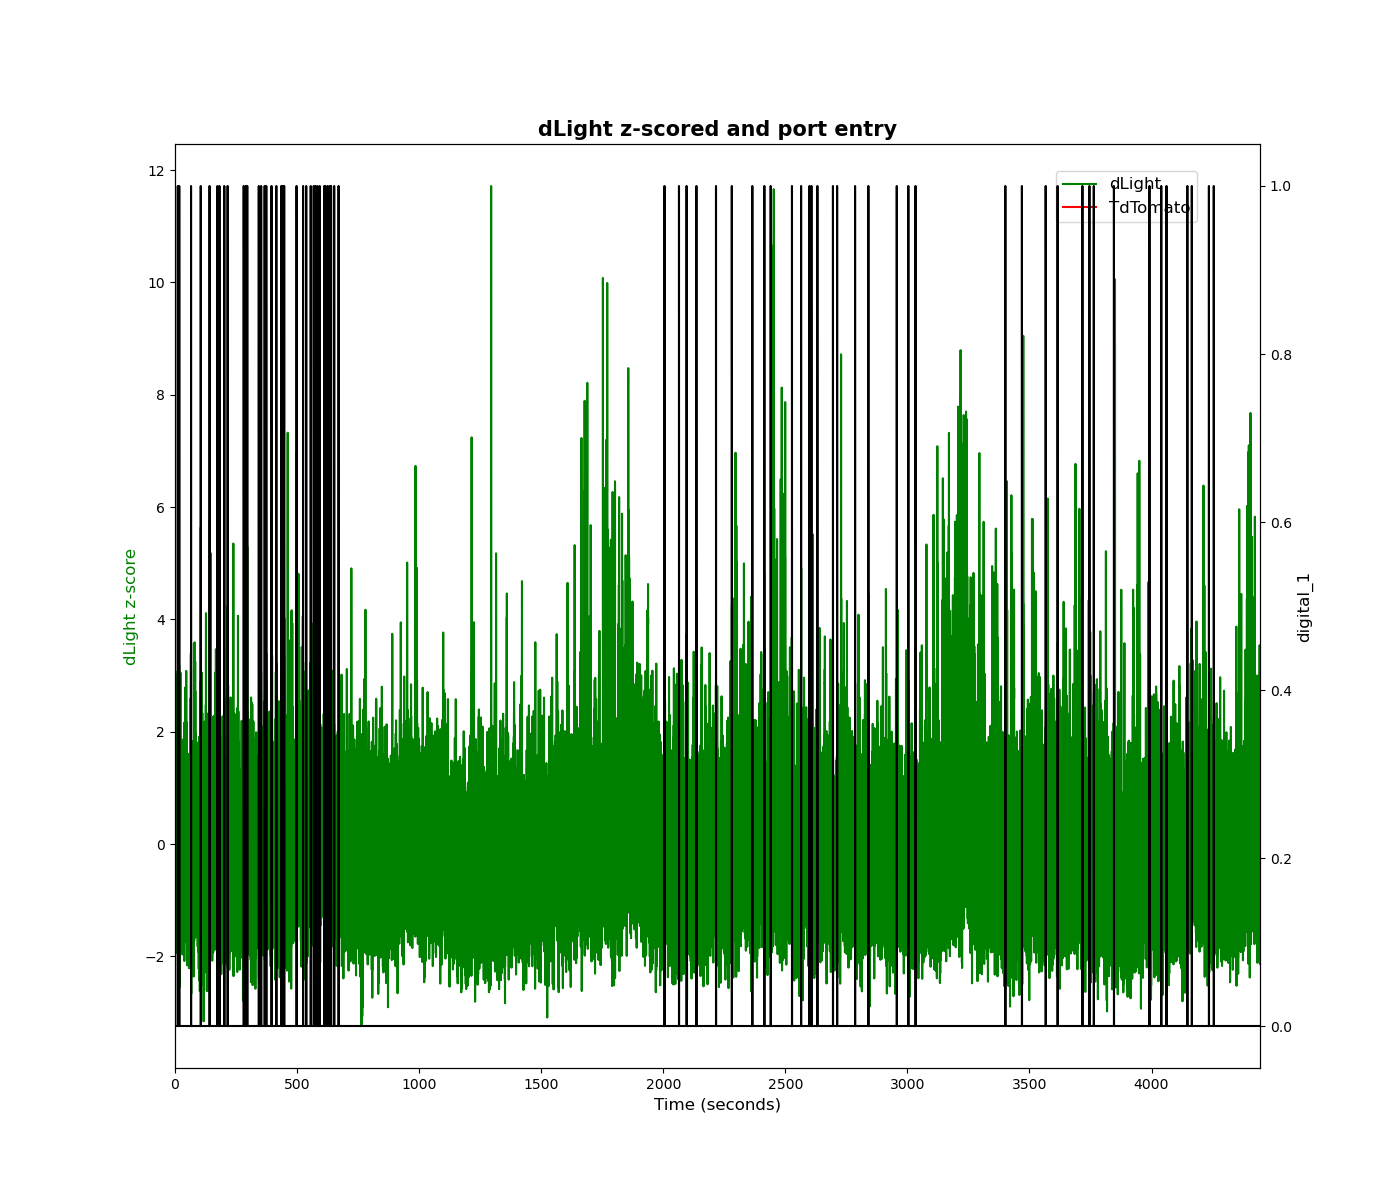

In [18]:
# Plot signals

fig,ax1=plt.subplots()  # create a plot to allow for dual y-axes plotting
plot1=ax1.plot(time_seconds, dLight_zscored, 'g', label='dLight z-score')
ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
plot2=ax2.plot(time_seconds, data['digital_1'], 'k', label='digital_1')  # Plot data

# ax1.set_ylim(1.25, 1.65)
# ax2.set_ylim(1.35, 1.75)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight z-score', color='g')
ax2.set_ylabel('digital_1', color='k')
ax1.set_title('dLight z-scored and port entry')

legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

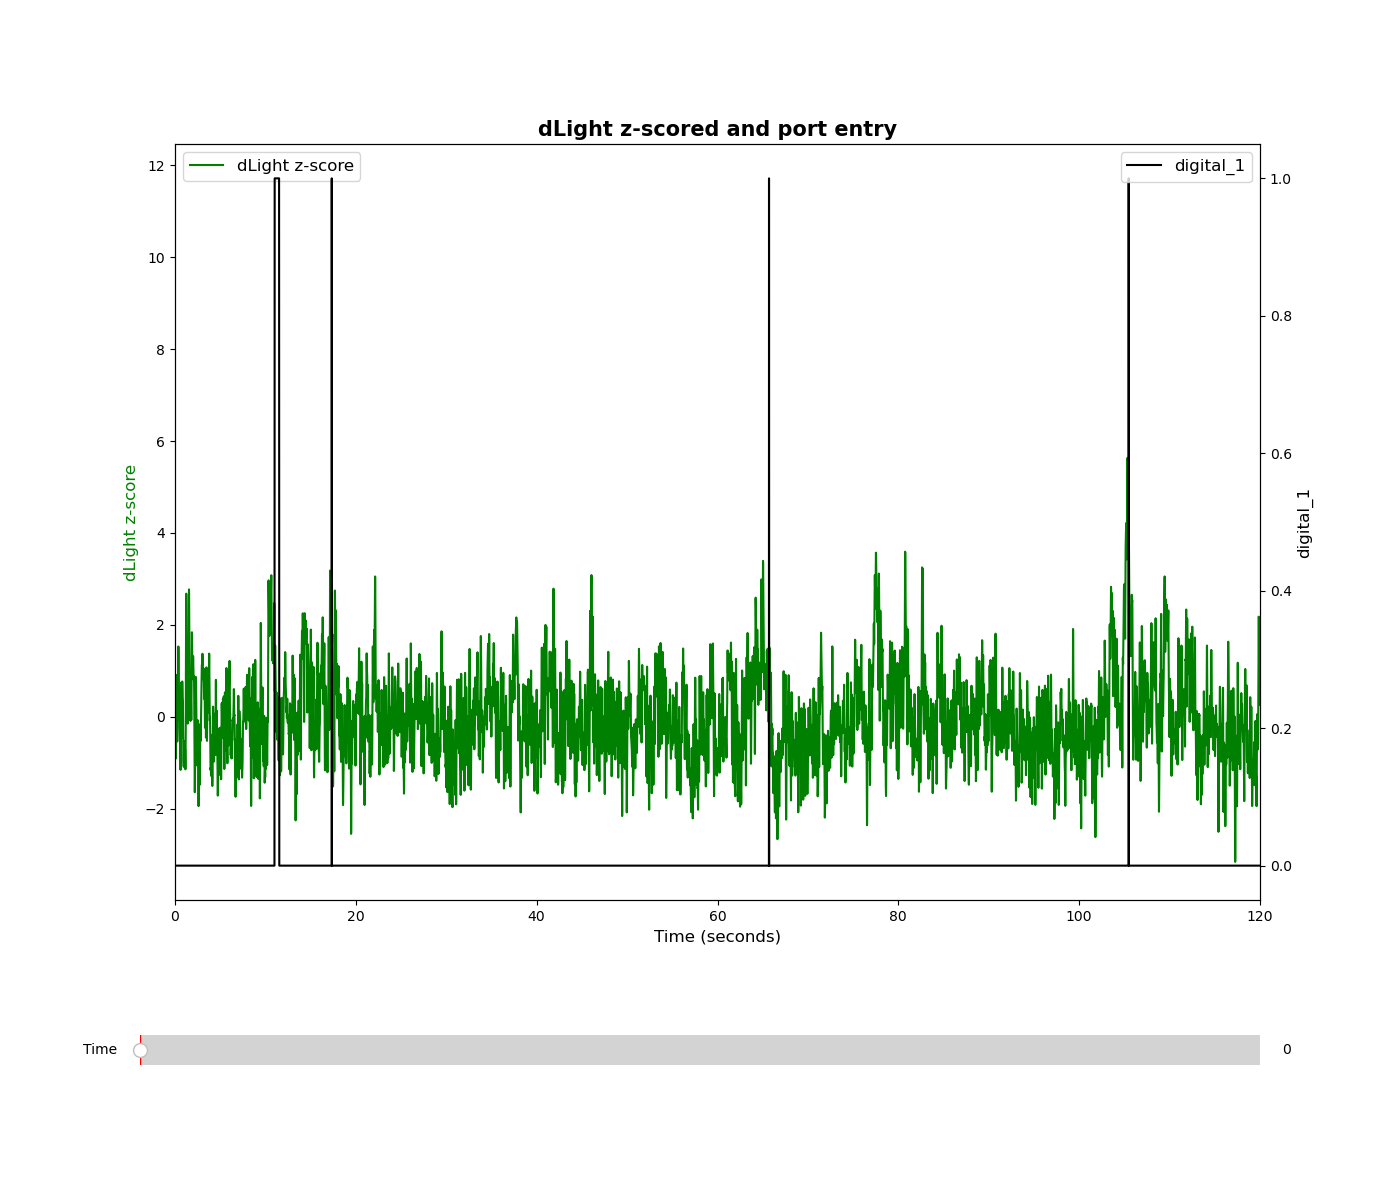

In [19]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Sample data generation
# Uncomment and adjust according to your actual data structure
# import numpy as np
# time_seconds = np.arange(0, 3600, 0.1)  # For example, 1 hour of data at 0.1s intervals
# dLight_zscored = np.random.normal(0, 1, len(time_seconds))  # Example synthetic data
# data = {'digital_1': np.random.randint(0, 2, len(time_seconds))}

# Setup the plot
fig, ax1 = plt.subplots()
plt.subplots_adjust(bottom=0.25)  # Adjust bottom to give space for the slider

ax2 = ax1.twinx()

# Plotting
ax1.plot(time_seconds, dLight_zscored, 'g', label='dLight z-score')
ax2.plot(time_seconds, data['digital_1'], 'k', label='digital_1')

# Set labels and title
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight z-score', color='g')
ax2.set_ylabel('digital_1', color='k')
ax1.set_title('dLight z-scored and port entry')

# Set the limits for the initial plot
ax1.set_xlim(0, 120)

# Create the slider
ax_slider = plt.axes([0.1, 0.1, 0.8, 0.05])  # position for the slider
slider = Slider(ax_slider, 'Time', 0, max(time_seconds) - 120, valinit=0, valstep=0.1)

# Update function for the slider
def update(val):
    start = slider.val
    ax1.set_xlim(start, start + 120)
    ax2.set_xlim(start, start + 120)
    fig.canvas.draw_idle()

# Register the update function with the slider
slider.on_changed(update)

# Show legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


(c) Copyright Thomas Akam & Lauren Burgeno 2019 - 2023.  Released under the [GPL3 Licence](https://www.gnu.org/licenses/gpl-3.0.en.html).